In [5]:
!mkdir -p coco/images coco/annotations

# Download images
!wget -c http://images.cocodataset.org/zips/train2017.zip -P coco/images
!wget -c http://images.cocodataset.org/zips/val2017.zip -P coco/images

# Download annotations
!wget -c http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P coco/

# Unzip them
!unzip -q coco/images/train2017.zip -d coco/images
!unzip -q coco/images/val2017.zip -d coco/images
!unzip -q coco/annotations_trainval2017.zip -d coco/

--2025-07-13 09:04:00--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.28.98, 3.5.27.80, 54.231.195.217, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.28.98|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘coco/images/train2017.zip’

train2017.zip       100%[===================>]  18.01G  13.2MB/s    in 23m 15s 

2025-07-13 09:27:15 (13.2 MB/s) - ‘coco/images/train2017.zip’ saved [19336861798/19336861798]

--2025-07-13 09:27:15--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.15.176.74, 3.5.28.97, 3.5.24.127, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.15.176.74|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘coco/images/val2017.zip’

val2017.zip         100%[======

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.datasets import CocoDetection
from PIL import Image

In [7]:
# 1. CONFIGURATION
DATA_DIR = './coco'
BATCH_SIZE = 16
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4
NUM_CLASSES = 91  # COCO has 80 classes + 1 background, we use 91 to match official annotation ids
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Yes, GPU is available." if torch.cuda.is_available() else "No GPU, using CPU.")

Yes, GPU is available.


In [8]:
# 2. DATASET DEFINITION
class TinyCocoDataset(Dataset):
    def __init__(self, root, annFile, transforms=None, max_samples=5000):
        self.dataset = CocoDetection(root=root, annFile=annFile)
        self.transforms = transforms
        self.max_samples = max_samples

    def __len__(self):
        return min(len(self.dataset), self.max_samples)

    def __getitem__(self, idx):
        img, targets = self.dataset[idx]
        if len(targets) == 0:
            return self.__getitem__((idx + 1) % len(self))  # skip images without objects
        target = targets[0]  # take the first object
        label = target['category_id']
        bbox = target['bbox']  # [x, y, width, height]
        x, y, w, h = bbox
        xmin = x / img.width
        ymin = y / img.height
        xmax = (x + w) / img.width
        ymax = (y + h) / img.height
        bbox_tensor = torch.tensor([xmin, ymin, xmax, ymax], dtype=torch.float32)
        if self.transforms:
            img = self.transforms(img)
        return img, label, bbox_tensor

In [9]:
# 3. DATA TRANSFORMS
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 4. DATA LOADERS
train_dataset = TinyCocoDataset(
    root=os.path.join(DATA_DIR, 'images', 'train2017'),
    annFile=os.path.join(DATA_DIR, 'annotations', 'instances_train2017.json'),
    transforms=data_transforms
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_dataset = TinyCocoDataset(
    root=os.path.join(DATA_DIR, 'images', 'val2017'),
    annFile=os.path.join(DATA_DIR, 'annotations', 'instances_val2017.json'),
    transforms=data_transforms
)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

loading annotations into memory...
Done (t=17.46s)
creating index...
index created!
loading annotations into memory...
Done (t=0.57s)
creating index...
index created!


In [10]:
# 5. MODEL DEFINITION
class DetectionModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        backbone = models.resnet18(pretrained=True)
        modules = list(backbone.children())[:-1]
        self.backbone = nn.Sequential(*modules)
        self.flatten = nn.Flatten()
        self.classifier = nn.Linear(backbone.fc.in_features, num_classes)
        self.bbox_regressor = nn.Linear(backbone.fc.in_features, 4)

    def forward(self, x):
        feats = self.backbone(x)
        feats = self.flatten(feats)
        cls_logits = self.classifier(feats)
        bbox_preds = self.bbox_regressor(feats)
        return cls_logits, bbox_preds

model = DetectionModel(NUM_CLASSES).to(DEVICE)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 201MB/s]


In [11]:
# 6. LOSS FUNCTIONS & OPTIMIZER
criterion_cls = nn.CrossEntropyLoss()
criterion_bbox = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [12]:
# 7. TRAINING LOOP
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for imgs, labels, bboxes in train_loader:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)
        bboxes = bboxes.to(DEVICE)

        optimizer.zero_grad()
        cls_logits, bbox_preds = model(imgs)
        loss_cls = criterion_cls(cls_logits, labels)
        loss_bbox = criterion_bbox(bbox_preds, bboxes)
        loss = loss_cls + loss_bbox
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {epoch_loss:.4f}')

Epoch 1/10, Loss: 2.7566
Epoch 2/10, Loss: 1.6073
Epoch 3/10, Loss: 0.9079
Epoch 4/10, Loss: 0.4203
Epoch 5/10, Loss: 0.1820
Epoch 6/10, Loss: 0.0905
Epoch 7/10, Loss: 0.0569
Epoch 8/10, Loss: 0.0480
Epoch 9/10, Loss: 0.0406
Epoch 10/10, Loss: 0.0357


In [13]:
# 8. TESTING LOOP - Classification Accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels, _ in test_loader:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)
        cls_logits, _ = model(imgs)
        _, preds = torch.max(cls_logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f'Test Classification Accuracy: {accuracy:.2f}%')

Test Classification Accuracy: 49.18%


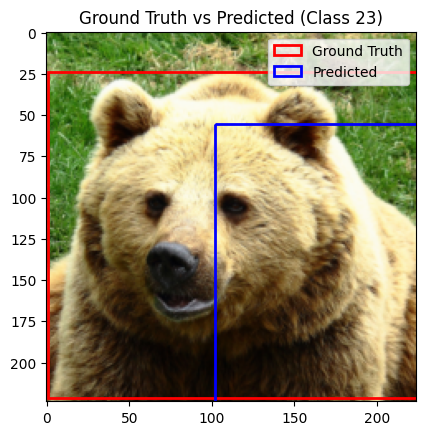

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Pick one sample from test set
model.eval()
img, label, bbox = test_dataset[1]  # image tensor, class id, true bbox
input_img = img.unsqueeze(0).to(DEVICE)  # add batch dimension

# Predict
with torch.no_grad():
    cls_logits, bbox_pred = model(input_img)
    pred_bbox = bbox_pred[0].cpu().numpy()

# Convert image to displayable format
img_disp = img.permute(1, 2, 0).cpu().numpy()
img_disp = img_disp * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # unnormalize
img_disp = img_disp.clip(0, 1)

# Create plot
fig, ax = plt.subplots(1)
ax.imshow(img_disp)

# Draw ground truth box (red)
h, w = img_disp.shape[:2]
xmin, ymin, xmax, ymax = bbox.numpy()
rect_gt = patches.Rectangle((xmin * w, ymin * h), (xmax - xmin) * w, (ymax - ymin) * h,
                            linewidth=2, edgecolor='r', facecolor='none', label='Ground Truth')
ax.add_patch(rect_gt)

# Draw predicted box (blue)
xmin_p, ymin_p, xmax_p, ymax_p = pred_bbox
rect_pred = patches.Rectangle((xmin_p * w, ymin_p * h), (xmax_p - xmin_p) * w, (ymax_p - ymin_p) * h,
                              linewidth=2, edgecolor='b', facecolor='none', label='Predicted')
ax.add_patch(rect_pred)

plt.legend()
plt.title(f'Ground Truth vs Predicted (Class {label})')
plt.show()